In [1]:
import time
import psycopg2
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from finance.utilities import utils
from finance.science.utilities import lstm_utils, options_utils, science_utils

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Get stock data

In [2]:
date_start = '2015-01-01'
date_end = '2020-07-20'
query = f'''
    with 
    tickers as (
        select distinct 
              ticker
            , sector
            , industry
        from nasdaq.listed_stocks
        where   ticker !~ '[\^.~]'
            and character_length(ticker) between 1 and 4
            and ticker in ('KO', 'JPM', 'AA')
        limit 30
        )
    , lagged as (
        select
              s.symbol
            , s.market_datetime
            , max(s.open) over (partition by s.symbol order by s.market_datetime rows between 1 following and 31 following) as target_max_open
            , s.open
            , lag(s.open, 1) over (partition by s.symbol order by s.market_datetime) as open_1
            , lag(s.open, 2) over (partition by s.symbol order by s.market_datetime) as open_2
            , lag(s.open, 3) over (partition by s.symbol order by s.market_datetime) as open_3
            , lag(s.open, 4) over (partition by s.symbol order by s.market_datetime) as open_4
            , lag(s.open, 5) over (partition by s.symbol order by s.market_datetime) as open_5
            , lag(s.open, 6) over (partition by s.symbol order by s.market_datetime) as open_6
            , lag(s.open, 7) over (partition by s.symbol order by s.market_datetime) as open_7
            , lag(s.open, 8) over (partition by s.symbol order by s.market_datetime) as open_8
            , lag(s.open, 9) over (partition by s.symbol order by s.market_datetime) as open_9
            , lag(s.open, 10) over (partition by s.symbol order by s.market_datetime) as open_10
            , lag(s.open, 11) over (partition by s.symbol order by s.market_datetime) as open_11
            , lag(s.open, 12) over (partition by s.symbol order by s.market_datetime) as open_12
            , lag(s.open, 13) over (partition by s.symbol order by s.market_datetime) as open_13
            , lag(s.open, 14) over (partition by s.symbol order by s.market_datetime) as open_14
            , lag(s.open, 15) over (partition by s.symbol order by s.market_datetime) as open_15
            , lag(s.open, 16) over (partition by s.symbol order by s.market_datetime) as open_16
            , lag(s.open, 17) over (partition by s.symbol order by s.market_datetime) as open_17
            , lag(s.open, 18) over (partition by s.symbol order by s.market_datetime) as open_18
            , lag(s.open, 19) over (partition by s.symbol order by s.market_datetime) as open_19
            , lag(s.open, 20) over (partition by s.symbol order by s.market_datetime) as open_20
            , lag(s.open, 21) over (partition by s.symbol order by s.market_datetime) as open_21
            , lag(s.open, 22) over (partition by s.symbol order by s.market_datetime) as open_22
            , lag(s.open, 23) over (partition by s.symbol order by s.market_datetime) as open_23
            , lag(s.open, 24) over (partition by s.symbol order by s.market_datetime) as open_24
            , lag(s.open, 25) over (partition by s.symbol order by s.market_datetime) as open_25
            , lag(s.open, 26) over (partition by s.symbol order by s.market_datetime) as open_26
            , lag(s.open, 27) over (partition by s.symbol order by s.market_datetime) as open_27
            , lag(s.open, 28) over (partition by s.symbol order by s.market_datetime) as open_28
            , lag(s.open, 29) over (partition by s.symbol order by s.market_datetime) as open_29
            , lag(s.open, 30) over (partition by s.symbol order by s.market_datetime) as open_30
        from td.stocks as s
        inner join tickers as t
            on t.ticker = s.symbol
        where s.market_datetime > '{date_start}' and s.market_datetime < '{date_end}'
        )
    , summarized as (
        select *
            , least(open_1, open_2, open_3, open_4, open_5, open_6, open_7, open_8, open_9, open_10, open_11, open_12, open_13, open_14, open_15, open_16, open_17, open_18, open_19, open_20, open_21, open_22, open_23, open_24, open_25, open_26, open_27, open_28, open_29, open_30) as open_min
            , greatest(open_1, open_2, open_3, open_4, open_5, open_6, open_7, open_8, open_9, open_10, open_11, open_12, open_13, open_14, open_15, open_16, open_17, open_18, open_19, open_20, open_21, open_22, open_23, open_24, open_25, open_26, open_27, open_28, open_29, open_30) as open_max
        from lagged
        where open_30 is not null
        )
    select
              symbol
            , market_datetime
            , target_max_open
            , open
            , open_min
            , open_max
            , (open - open_min) / (open_max - open_min) as normalized_open
            , (open_1 - open_min) / (open_max - open_min) as open_1
            , (open_2 - open_min) / (open_max - open_min) as open_2
            , (open_3 - open_min) / (open_max - open_min) as open_3
            , (open_4 - open_min) / (open_max - open_min) as open_4
            , (open_5 - open_min) / (open_max - open_min) as open_5
            , (open_6 - open_min) / (open_max - open_min) as open_6
            , (open_7 - open_min) / (open_max - open_min) as open_7
            , (open_8 - open_min) / (open_max - open_min) as open_8
            , (open_9 - open_min) / (open_max - open_min) as open_9
            , (open_10 - open_min) / (open_max - open_min) as open_10
            , (open_11 - open_min) / (open_max - open_min) as open_11
            , (open_12 - open_min) / (open_max - open_min) as open_12
            , (open_13 - open_min) / (open_max - open_min) as open_13
            , (open_14 - open_min) / (open_max - open_min) as open_14
            , (open_15 - open_min) / (open_max - open_min) as open_15
            , (open_16 - open_min) / (open_max - open_min) as open_16
            , (open_17 - open_min) / (open_max - open_min) as open_17
            , (open_18 - open_min) / (open_max - open_min) as open_18
            , (open_19 - open_min) / (open_max - open_min) as open_19
            , (open_20 - open_min) / (open_max - open_min) as open_20
            , (open_21 - open_min) / (open_max - open_min) as open_21
            , (open_22 - open_min) / (open_max - open_min) as open_22
            , (open_23 - open_min) / (open_max - open_min) as open_23
            , (open_24 - open_min) / (open_max - open_min) as open_24
            , (open_25 - open_min) / (open_max - open_min) as open_25
            , (open_26 - open_min) / (open_max - open_min) as open_26
            , (open_27 - open_min) / (open_max - open_min) as open_27
            , (open_28 - open_min) / (open_max - open_min) as open_28
            , (open_29 - open_min) / (open_max - open_min) as open_29
            , (open_30 - open_min) / (open_max - open_min) as open_30
    from summarized
    order by market_datetime, symbol
    '''

df = utils.query_db(query=query)
df.head()

,symbol,market_datetime,target_max_open,open,open_min,open_max,normalized_open,open_1,open_2,open_3,...,open_21,open_22,open_23,open_24,open_25,open_26,open_27,open_28,open_29,open_30
0,AA,2015-02-17,47.79,47.52,44.88,51.00,0.431373,0.411765,0.367647,0.382353,...,0.098039,0.245098,0.740196,0.705882,0.524510,0.343137,0.156863,0.029412,0.333333,0.446078
1,JPM,2015-02-17,62.20,59.36,54.53,62.62,0.597033,0.609394,0.543881,0.436341,...,0.148331,0.294190,0.584672,0.587145,0.765142,0.672435,0.662546,0.755253,0.930779,1.000000
2,KO,2015-02-17,43.12,41.81,41.21,43.60,0.251046,0.338912,0.497908,0.372385,...,0.677824,0.364017,0.677824,0.778243,0.945607,0.824268,0.665272,0.502092,0.619247,0.439331
3,AA,2015-02-18,47.79,47.19,44.88,51.00,0.377451,0.431373,0.411765,0.367647,...,0.000000,0.098039,0.245098,0.740196,0.705882,0.524510,0.343137,0.156863,0.029412,0.333333
4,JPM,2015-02-18,62.20,59.79,54.53,62.06,0.698539,0.641434,0.654714,0.584329,...,0.017264,0.159363,0.316069,0.628154,0.630810,0.822045,0.722444,0.711819,0.811421,1.000000


### Clean data

In [3]:
SYMBOL = 'symbol'

OPEN = 'open'
OPEN_MIN = 'open_min'
OPEN_MAX = 'open_max'
NORMALIZED_OPEN = 'normalized_open'

TARGET_MAX_OPEN = 'target_max_open'

COLS_TO_IGNORE = [SYMBOL, 'market_datetime', TARGET_MAX_OPEN, OPEN, OPEN_MIN, OPEN_MAX, NORMALIZED_OPEN]

In [4]:
df = science_utils.encode_one_hot(df, [SYMBOL])
df.head(10)

,symbol,market_datetime,target_max_open,open,open_min,open_max,normalized_open,open_1,open_2,open_3,...,open_24,open_25,open_26,open_27,open_28,open_29,open_30,symbol_AA,symbol_JPM,symbol_KO
0,AA,2015-02-17,47.79,47.52,44.88,51.00,0.431373,0.411765,0.367647,0.382353,...,0.705882,0.524510,0.343137,0.156863,0.029412,0.333333,0.446078,1,0,0
1,JPM,2015-02-17,62.20,59.36,54.53,62.62,0.597033,0.609394,0.543881,0.436341,...,0.587145,0.765142,0.672435,0.662546,0.755253,0.930779,1.000000,0,1,0
2,KO,2015-02-17,43.12,41.81,41.21,43.60,0.251046,0.338912,0.497908,0.372385,...,0.778243,0.945607,0.824268,0.665272,0.502092,0.619247,0.439331,0,0,1
3,AA,2015-02-18,47.79,47.19,44.88,51.00,0.377451,0.431373,0.411765,0.367647,...,0.740196,0.705882,0.524510,0.343137,0.156863,0.029412,0.333333,1,0,0
4,JPM,2015-02-18,62.20,59.79,54.53,62.06,0.698539,0.641434,0.654714,0.584329,...,0.628154,0.630810,0.822045,0.722444,0.711819,0.811421,1.000000,0,1,0
5,KO,2015-02-18,43.12,41.75,41.21,43.60,0.225941,0.251046,0.338912,0.497908,...,0.677824,0.778243,0.945607,0.824268,0.665272,0.502092,0.619247,0,0,1
6,AA,2015-02-19,47.79,47.34,44.88,51.00,0.401961,0.377451,0.431373,0.411765,...,0.245098,0.740196,0.705882,0.524510,0.343137,0.156863,0.029412,1,0,0
7,JPM,2015-02-19,62.20,59.15,54.53,60.72,0.746365,0.849758,0.780291,0.796446,...,0.384491,0.764136,0.767367,1.000000,0.878837,0.865913,0.987076,0,1,0
8,KO,2015-02-19,43.12,41.68,41.21,43.60,0.196653,0.225941,0.251046,0.338912,...,0.364017,0.677824,0.778243,0.945607,0.824268,0.665272,0.502092,0,0,1
9,AA,2015-02-20,46.98,47.79,44.88,51.00,0.475490,0.401961,0.377451,0.431373,...,0.098039,0.245098,0.740196,0.705882,0.524510,0.343137,0.156863,1,0,0


### Train lstm

In [5]:
size = int(round(len(df)/2, -2))

train = df.head(size)
test = df.tail(int(size/2))

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torch/nn/modules/rnn.py:179: RuntimeWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  self.dropout, self.training, self.bidirectional, self.batch_first)


Batch 1, Epoch 0, Loss 1226.245849609375
Batch 1, Epoch 25, Loss 1012.1300659179688
Batch 1, Epoch 50, Loss 644.3611450195312
Batch 1, Epoch 75, Loss 547.4173583984375
Batch 1, Epoch 100, Loss 450.9421081542969
Batch 1, Epoch 125, Loss 393.06451416015625
Batch 1, Epoch 150, Loss 358.4212951660156
Batch 1, Epoch 175, Loss 331.0942687988281
Batch 1, Epoch 200, Loss 309.45294189453125
Batch 1, Epoch 225, Loss 289.3620300292969


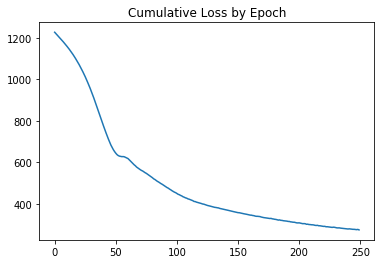

In [6]:
model = lstm_utils.TorchLSTM(
    train_x=train.drop(COLS_TO_IGNORE, axis=1),
    train_y=train[NORMALIZED_OPEN],
    test_x=test.drop(COLS_TO_IGNORE, axis=1),
    test_y=test[NORMALIZED_OPEN],
    n_layers=2,
    n_training_batches=1,
    n_epochs=250,
    hidden_shape=1000,
    dropout=0.1,
    learning_rate=.0001,
    seed=44,
)

model.fit()
prediction = model.prediction_df

In [7]:
PREDICTION = 'prediction'
DENORMALIZED_PREDICTION = 'denormalized_prediction'

res = test[COLS_TO_IGNORE].join(prediction)

res[DENORMALIZED_PREDICTION] = res[PREDICTION] * (df[OPEN_MAX] - df[OPEN_MIN]) + df[OPEN_MIN]
res.head()

,symbol,market_datetime,target_max_open,open,open_min,open_max,normalized_open,open_1,open_2,open_3,...,open_26,open_27,open_28,open_29,open_30,symbol_AA,symbol_JPM,symbol_KO,prediction,denormalized_prediction
3095,KO,2019-03-22,48.95,45.46,44.60,49.69,0.168959,0.182711,0.157171,0.186640,...,0.984283,1.000000,0.976424,0.937132,0.897839,0,0,1,0.220136,45.720491
3096,AA,2019-03-25,29.55,28.12,26.76,31.07,0.315545,0.542923,0.412993,0.403712,...,0.457077,0.475638,0.364269,0.183295,0.083527,1,0,0,0.505189,28.937364
3097,JPM,2019-03-25,116.43,99.59,101.76,108.20,-0.336957,0.009317,0.268634,0.725155,...,0.110248,0.177019,0.029503,0.000000,0.049689,0,1,0,0.347123,103.995470
3098,KO,2019-03-25,48.95,45.86,44.60,49.69,0.247544,0.168959,0.182711,0.157171,...,0.412574,0.984283,1.000000,0.976424,0.937132,0,0,1,0.210460,45.671241
3099,AA,2019-03-26,29.55,28.14,26.76,31.07,0.320186,0.315545,0.542923,0.412993,...,0.452436,0.457077,0.475638,0.364269,0.183295,1,0,0,0.413661,28.542879


### Evaluate predictions

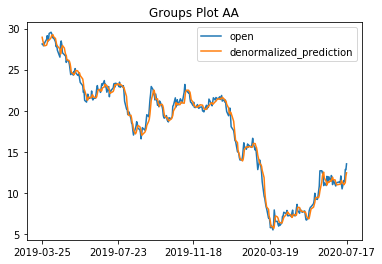

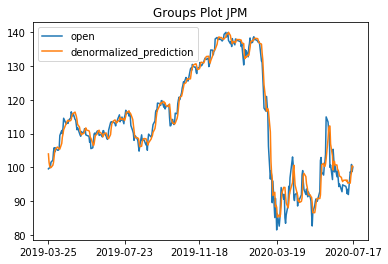

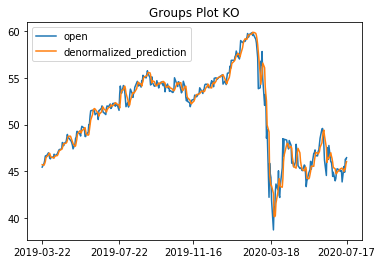

In [8]:
science_utils.plot_groups(res, SYMBOL, [OPEN, DENORMALIZED_PREDICTION])

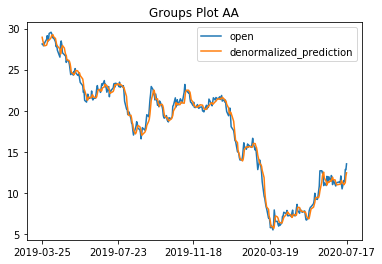

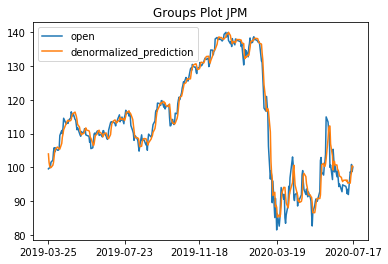

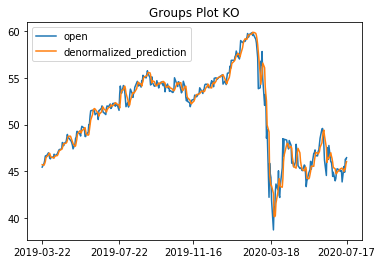

In [9]:
science_utils.plot_groups(res, SYMBOL, [OPEN, DENORMALIZED_PREDICTION])

### Get options data

In [10]:
date_start = '2020-08-05'
date_end = '2020-08-05'
query = f'''
    with 
    tickers as (
      select distinct 
          ticker
        , sector
        , industry
      from nasdaq.listed_stocks
      where ticker !~ '[\^.~]'
        and character_length(ticker) between 1 and 4
        and ticker in ('KO', 'JPM')
      limit 30
      )
    , stocks as (
      select
          s.market_datetime
        , s.symbol
        , s.close
      from td.stocks as s
      inner join tickers as t
        on t.ticker = s.symbol
      where s.market_datetime between '{date_start}' and '{date_end}'
      )
    , options as (
      select
          o.symbol
        , o.file_datetime
        , o.put_call
        , o.strike
        , o.days_to_expiration
        , o.last
        , (o.bid + o.ask) / 2 as bid_ask
        , o.volatility
        , o.expiration_date_from_epoch
      from td.options as o
      inner join tickers as t
        on t.ticker = o.symbol
      where o.file_datetime between '{date_start}' and '{date_end}'
      )
    , final as (
      select distinct
          s.market_datetime
        , s.symbol
        , s.close
        , o.put_call
        , o.strike
        , o.days_to_expiration as days_to_maturity
        , o.last
        , o.bid_ask
        , o.volatility
        , o.expiration_date_from_epoch
      from stocks as s
      inner join options as o
        on  s.market_datetime = o.file_datetime
        and s.symbol = o.symbol
      order by
          s.market_datetime
        , s.symbol
        , o.put_call
        , o.strike
        , o.days_to_expiration
      )
    select *
    from final
    '''

options = utils.query_db(query=query)
options.head()

,market_datetime,symbol,close,put_call,strike,days_to_maturity,last,bid_ask,volatility,expiration_date_from_epoch
0,2020-08-05,JPM,97.21,CALL,45.0,44.0,53.35,52.275,29.0,2020-09-18 20:00:00
1,2020-08-05,JPM,97.21,CALL,45.0,135.0,53.65,52.325,29.0,2020-12-18 21:00:00
2,2020-08-05,JPM,97.21,CALL,45.0,163.0,52.39,52.325,29.0,2021-01-15 21:00:00
3,2020-08-05,JPM,97.21,CALL,45.0,226.0,51.00,52.375,29.0,2021-03-19 20:00:00
4,2020-08-05,JPM,97.21,CALL,45.0,317.0,53.90,52.425,29.0,2021-06-18 20:00:00


In [11]:
x = options.iloc[206]
x

market_datetime                        2020-08-05
symbol                                        JPM
close                                       97.21
put_call                                     CALL
strike                                         95
days_to_maturity                               44
last                                         5.71
bid_ask                                     5.575
volatility                                     29
expiration_date_from_epoch    2020-09-18 20:00:00
Name: 206, dtype: object

In [12]:
vols = options_utils.BlackScholes(
    current_option_price=x['last'],
    stock_price=x['close'],
    strike=x['strike'],
    risk_free_rate=.001,
    days_to_maturity=x['days_to_maturity'],
    is_call=x['put_call']=='CALL',
)
print(vols.implied_volatility)

0.3392189625243722
